<a href="https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector_augmentated_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [ ]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'

In [228]:
import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
#%matplotlib inline

#from pycocotools.coco import COCO
#import fiftyone as fo
import time
import torch
import torch.nn as nn
#import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN
from torchvision.models import resnet152
#import cv2
#PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

## Обучение модели

### Загрузчик данных

In [327]:
class RTSD_dataset_classifier(Dataset):
    def __init__(self, json_path, img_path, transforms):
        self.json_path = json_path
        self.img_path = img_path
        self.tranfforms = transforms
        with open(json_path, 'r') as read_file:
            self.anno = json.load(read_file)
        read_file.close()

        self.df_anno = pd.DataFrame(self.anno.get('annotations'))[['image_id','bbox','category_id']]
        self.df_images = pd.DataFrame(self.anno.get('images'))[['id','file_name']]
        self.df_dataset = self.df_anno.merge(self.df_images, left_on='image_id', right_on='id',)[['file_name','bbox','category_id']]
    
    def __len__(self):
        return self.df_dataset.shape[0]

    def __getitem__(self, index):
        img_name = self.df_dataset.loc[index,'file_name']
        bbox = self.df_dataset.loc[index,'bbox']
        bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        img = Image.open(os.path.join(self.img_path, img_name))
        img = img.crop(bbox)
        img = self.tranfforms(img)
        label = torch.tensor(self.df_dataset.loc[index,'category_id'])
        
        return {'images':img, 'labels':label}

In [328]:
def get_transform(train):
    if train == True:
        return transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                   #transforms.Normalize([0.496, 0.456, 0.406],
                                   #                     [0.229, 0.224, 0.225])
                                   ])
    else:
        return transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                   #transforms.Normalize([0.496, 0.456, 0.406],
                                   #                     [0.229, 0.224, 0.225])
                                   ])

In [293]:
test = RTSD_dataset_classifier(json_path = os.path.join(dataset_path, 'train_anno_reduced.json'),
                               img_path = dataset_path,
                               transforms = get_transform(train=True)
                               )

In [341]:
test.__getitem__(5)

{'images': tensor([[[0.9020, 0.9020, 0.9020,  ..., 0.8941, 0.8941, 0.8941],
          [0.9020, 0.9020, 0.9020,  ..., 0.8941, 0.8941, 0.8941],
          [0.9020, 0.9020, 0.9020,  ..., 0.8941, 0.8941, 0.8941],
          ...,
          [0.9059, 0.9059, 0.9059,  ..., 0.9412, 0.9412, 0.9412],
          [0.9059, 0.9059, 0.9059,  ..., 0.9412, 0.9412, 0.9412],
          [0.9059, 0.9059, 0.9059,  ..., 0.9412, 0.9412, 0.9412]],
 
         [[0.9020, 0.9020, 0.9020,  ..., 0.8588, 0.8588, 0.8588],
          [0.9020, 0.9020, 0.9020,  ..., 0.8588, 0.8588, 0.8588],
          [0.9020, 0.9020, 0.9020,  ..., 0.8588, 0.8588, 0.8588],
          ...,
          [0.9137, 0.9137, 0.9137,  ..., 0.9255, 0.9255, 0.9255],
          [0.9137, 0.9137, 0.9137,  ..., 0.9255, 0.9255, 0.9255],
          [0.9137, 0.9137, 0.9137,  ..., 0.9255, 0.9255, 0.9255]],
 
         [[0.8941, 0.8941, 0.8941,  ..., 0.8784, 0.8784, 0.8784],
          [0.8941, 0.8941, 0.8941,  ..., 0.8784, 0.8784, 0.8784],
          [0.8941, 0.8941, 0.8

155

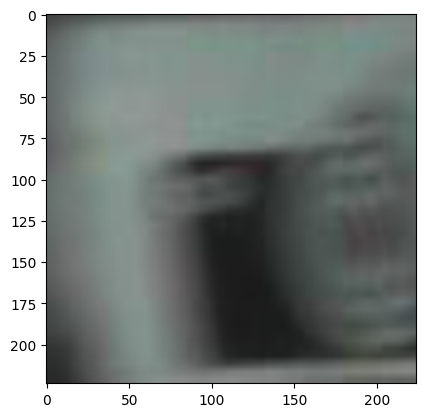

In [295]:
def plot_sign(index):
    item = test.__getitem__(index)
    img = item['images']
    img = img.permute(1, 2, 0).detach().numpy()
    img = img*255
    img = img.astype(np.uint8)
    target = item['labels']
    fig, a = plt.subplots(1,1)
    #fig.set_size_inches(10,10)
    display(int(target.cpu().detach().numpy()))
    a.imshow(img)
    return None
plot_sign(2324)

### Формирование батча

In [329]:
def collate_fn(batch):
    return tuple(zip(*batch))

### Гиперпараметры

In [330]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'
n_epochs = 10
batch_size = 16
num_classes = 155

In [331]:
device

'mps'

### Инициализация модели, задание оптимизатора и функции потерь

In [332]:
def create_model(num_classes):
    model = resnet152(weights='ResNet152_Weights.IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = nn.Sequential(nn.Linear(2048, 1024), nn.Linear(1024, num_classes))
    for param in model.fc.parameters():
        param.requires_grad = True

    #torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    #in_features = model.roi_heads.box_predictor.cls_score.in_features
    #model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [333]:
model = create_model(num_classes=155).to(device)

loss_function = nn.CrossEntropyLoss

# parameters
##params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)



#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
train_dataset = RTSD_dataset_classifier(json_path = os.path.join(dataset_path, 'train_anno_reduced.json'),
                                        img_path = dataset_path,
                                        transforms = get_transform(train=True)
                                        )
val_dataset = RTSD_dataset_classifier(os.path.join(dataset_path, 'val_anno.json'),
                                        dataset_path,
                                          transforms = get_transform(train=False)
                                          )

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

### Трейн луп

In [339]:
train_data_loader

In [335]:
for batch_idx, data in enumerate(train_data_loader):
    a = data
    break

In [340]:
a

(('images',
  'images',
  'images',
  'images',
  'images',
  'images',
  'images',
  'images',
  'images',
  'images',
  'images',
  'images',
  'images',
  'images',
  'images',
  'images'),
 ('labels',
  'labels',
  'labels',
  'labels',
  'labels',
  'labels',
  'labels',
  'labels',
  'labels',
  'labels',
  'labels',
  'labels',
  'labels',
  'labels',
  'labels',
  'labels'))

In [273]:
a.keys()

AttributeError: 'tuple' object has no attribute 'keys'

In [325]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)

    training_loss=0
    correct = 0.0
    total = 0.0

    model.train()
    running_loss = 0        # training_loss
    for batch_idx, data in enumerate(train_dataloader):
        
        
        
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        
        output = model(images)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step
        
        training_loss =  + ((1/(batch_idx+1))*(loss.data-training_loss))
        if batch_idx%50 == 0:
            print(f"Training loss {training_loss}")
            print(loss.item())

        pred = output.data.max(1,keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        print(f"Accuracy on batch {batch_idx} on Training id {100*correct/total}")


        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #loss_dict = model(images, targets)
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss.item()
        #loss.backward()
        #optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f"\tЭпоха {epoch}. Итерация {batch_idx}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

In [326]:
train_losses = []
val_losses = []
try:
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        #val_loss = val(val_data_loader, epoch)
        val_loss = 0 # удалить потом
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        #val_losses.append(val_loss)
        '''torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(checkpoints_path, f'chkpt_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_{model_name}_{epoch}.pth'))'''
    
except KeyboardInterrupt:
    print('Прервано пользователем')

TypeError: conv2d() received an invalid combination of arguments - got (tuple, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple of (Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor)!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple of (Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor)!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [15]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [21]:
last_epoch = 2
# Загрузка весов модели
checkpoint = torch.load(os.path.join(checkpoints_path, f'model_detector_resnet50_augmented_{last_epoch}.pth'), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
#epoch = checkpoint['epoch']
train_losses = checkpoint['losses_train']
val_losses = checkpoint['losses_val']

In [28]:
checkpoint['losses_train'], checkpoint['losses_val']

([0.006822872471820277,
  0.00596496530648258,
  0.005799468892012618,
  0.005696767864120071],
 [0.0056146160304546356,
  0.005224747147411108,
  0.005272344498336315,
  0.005582686723768711])

In [ ]:
if last_epoch == None:
    train_losses = []
    val_losses = []
else:
    # Загрузка весов модели
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    #epoch = checkpoint['epoch']
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']

In [27]:
last_epoch = 3
model_name = 'detector_resnet50_augmented'


if last_epoch == None:
    train_losses = []
    val_losses = []
else:
    # Загрузка весов модели
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    #epoch = checkpoint['epoch']
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']

In [24]:
model_name = 'detector_resnet50_augmented'

In [29]:
try:
    for epoch in range(last_epoch + 1, n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(checkpoints_path, f'chkpt_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_{model_name}_{epoch}.pth'))
    
except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 4. Итерация 0/3387. Loss: 0.11603625863790512
	Эпоха 4. Итерация 50/3387. Loss: 0.09132763743400574
	Эпоха 4. Итерация 100/3387. Loss: 0.09525351226329803
	Эпоха 4. Итерация 150/3387. Loss: 0.08201088011264801
	Эпоха 4. Итерация 200/3387. Loss: 0.11788337677717209
	Эпоха 4. Итерация 250/3387. Loss: 0.09946923702955246
	Эпоха 4. Итерация 300/3387. Loss: 0.09350793063640594
	Эпоха 4. Итерация 350/3387. Loss: 0.09657343477010727
	Эпоха 4. Итерация 400/3387. Loss: 0.08998836576938629
	Эпоха 4. Итерация 450/3387. Loss: 0.08942896872758865
	Эпоха 4. Итерация 500/3387. Loss: 0.0664619505405426
	Эпоха 4. Итерация 550/3387. Loss: 0.08274924755096436
	Эпоха 4. Итерация 600/3387. Loss: 0.06323593109846115
	Эпоха 4. Итерация 650/3387. Loss: 0.07226131856441498
	Эпоха 4. Итерация 700/3387. Loss: 0.07295990735292435
	Эпоха 4. Итерация 750/3387. Loss: 0.06773833930492401
	Эпоха 4. Итерация 800/3387. Loss: 0.11777892708778381
	Эпоха 4. Итерация 850/3387. Loss: 0.09019037336111069
	Эпоха 4. Итер

In [26]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(checkpoints_path, f'chkpt_{model_name}_{epoch}.pth'))
    
torch.save(model, os.path.join(checkpoints_path, f'model_{model_name}_{epoch}.pth'))

In [ ]:
checkpoints_path

'../checkpoints'

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(checkpoints_path, f'model_detector_resnet50_augmented_{epoch}.pth'))

In [ ]:
checkpoint2 = torch.load(os.path.join('checkpoints', f'model_detector_resnet50_augmented_2.pth'), map_location=device)


In [ ]:
checkpoint3 = torch.load(os.path.join('checkpoints', f'model_detector_resnet50_augmented_3.pth'), map_location=device)

In [ ]:
checkpoint2['losses_train']

[0.006822872471820277, 0.00596496530648258, 0.005799468892012618]

In [ ]:
checkpoint3['losses_train']

[0.006822872471820277,
 0.00596496530648258,
 0.005799468892012618,
 0.011846726517383244]

In [ ]:
train_losses, val_losses

([0.014400107387186303], [0.010745501028001309])

In [ ]:
'''torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'losses_train': train_losses,
    'losses_val': val_losses
    }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_{epoch}.pth'))'''

In [ ]:
def create_model(num_classes, pretrained=True):
    model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
model = create_model(num_classes=2, pretrained=True).to(device)




# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

#params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)



#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno_bin_class.json'),
                                          dataset_path)
val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno_bin_class.json'), dataset_path)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to C:\Users\User/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [ ]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [ ]:
train_losses = []
val_losses = []
try:
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_{epoch}.pth'))
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'losses_train': train_losses,
    'losses_val': val_losses
    }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_full.pth'))
except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 0. Итерация 0/6774. Loss: 0.8358988165855408
	Эпоха 0. Итерация 50/6774. Loss: 0.09858530014753342
	Эпоха 0. Итерация 100/6774. Loss: 0.2172754555940628
	Эпоха 0. Итерация 150/6774. Loss: 0.40015822649002075
	Эпоха 0. Итерация 200/6774. Loss: 0.13395972549915314
	Эпоха 0. Итерация 250/6774. Loss: 0.28839361667633057
	Эпоха 0. Итерация 300/6774. Loss: 0.2116183489561081
	Эпоха 0. Итерация 350/6774. Loss: 0.2833598256111145
	Эпоха 0. Итерация 400/6774. Loss: 0.2793215811252594
	Эпоха 0. Итерация 450/6774. Loss: 0.309714674949646
	Эпоха 0. Итерация 500/6774. Loss: 0.20718857645988464
	Эпоха 0. Итерация 550/6774. Loss: 0.26163995265960693
	Эпоха 0. Итерация 600/6774. Loss: 0.35022008419036865
	Эпоха 0. Итерация 650/6774. Loss: 0.25102320313453674
	Эпоха 0. Итерация 700/6774. Loss: 0.36677470803260803
	Эпоха 0. Итерация 750/6774. Loss: 0.34893864393234253
	Эпоха 0. Итерация 800/6774. Loss: 0.32514622807502747
	Эпоха 0. Итерация 850/6774. Loss: 0.2878253161907196
	Эпоха 0. Итерация 90

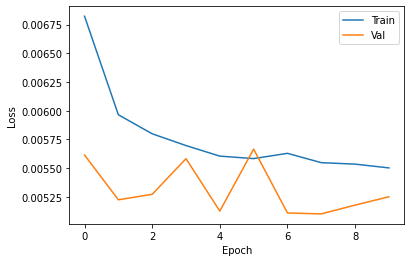

In [30]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
#ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()